<a href="https://colab.research.google.com/github/tram-tr/predicting-molecular-properties/blob/main/models_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# need authorization code to mount drive
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle

Mounted at /content/drive
env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/Colab Notebooks/Kaggle


In [1]:
!pip install kaggle
!kaggle competitions download -c champs-scalar-coupling
!pip install ase # visualize molecule

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [2]:
!pip install openbabel-wheel

In [3]:
!pip install rdkit

In [4]:
!pip install hyperopt

In [16]:
!pip install --upgrade xgboost

In [1]:
import pandas as pd
import numpy as np
import ase
import ase.visualize
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from collections import Counter, namedtuple
import scipy.sparse as sparse
from openbabel import pybel
from openbabel import openbabel
from scipy.sparse import csr_matrix
from typing import List
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform, randint
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from xgboost import XGBRFRegressor
import pickle
import time

In [3]:
train = pd.read_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/train_extend.csv')
test = pd.read_csv('drive/MyDrive/senior-yr/spring-2024/cse-60625/test_extend.csv')

In [4]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_bond,target_atom,n_bonds,min_d,...,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0,mulliken_charge_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,C,4,1.091946,...,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,-0.535689
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,C,4,1.091946,...,4,0,0,0,5,0.000012,0.873562,1.091954,0.133922,-0.535689
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,1,C,4,1.091946,...,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,1,C,4,1.091946,...,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,H,4,1.091946,...,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,0.133922


In [5]:
train.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'type_bond', 'target_atom', 'n_bonds',
       'min_d', 'mean_d', 'max_d', 'space_dist', 'bond_dist', 'bond_1',
       'bond_2', 'bond_3', 'atom_0_pc', 'target_atom_pc', 'atom_0_fc',
       'target_atom_fc', 'atom_0_val', 'target_atom_val', 'atom_0_sm',
       'target_atom_sm', 'atom_0_symbol', 'atom_2_symbol', 'atom_3_symbol',
       'target_atom_symbol', 'atom_0_hyb', 'atom_2_hyb', 'atom_3_hyb',
       'target_atom_hyb', 'path_count', 'bond_angle', 'dihedral_angle',
       'atom_0_min', 'atom_0_mean', 'atom_0_max', 'atom_0_Cmin',
       'atom_0_Cmean', 'atom_0_Cmax', 'atom_0_Omin', 'atom_0_Omean',
       'atom_0_Omax', 'atom_0_Nmin', 'atom_0_Nmean', 'atom_0_Nmax',
       'atom_0_Fmin', 'atom_0_Fmean', 'atom_0_Fmax', 'target_atom_min',
       'target_atom_mean', 'target_atom_max', 'target_atom_Cmin',
       'target_atom_Cmean', 'target_atom_Cmax', 'target_atom_Omin',
       'target_

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
def encode(df):
  encoding = {
    'H': 1,
    'C': 2,
    'N': 3,
    'O': 4,
    'F': 5,
    '': -1,
  }
  df['target_atom'] = df.target_atom.map(encoding)
  df['atom_2_symbol'] = df.atom_2_symbol.map(encoding)
  df['atom_3_symbol'] = df.atom_3_symbol.map(encoding)
  return df

In [8]:
train = encode(train)
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_bond,target_atom,n_bonds,min_d,mean_d,max_d,space_dist,bond_dist,bond_1,bond_2,bond_3,atom_0_pc,target_atom_pc,atom_0_fc,target_atom_fc,atom_0_val,target_atom_val,atom_0_sm,target_atom_sm,atom_0_symbol,atom_2_symbol,atom_3_symbol,target_atom_symbol,atom_0_hyb,atom_2_hyb,atom_3_hyb,target_atom_hyb,path_count,bond_angle,dihedral_angle,atom_0_min,atom_0_mean,atom_0_max,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,target_atom_min,target_atom_mean,target_atom_max,target_atom_Cmin,target_atom_Cmean,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax,is_linear,center_dist_0,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0,mulliken_charge_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,2,4,1.091946,1.506668,1.783158,1.091953,1.091953,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091953,1.610344,1.783157,1.091953,1.091953,1.091953,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091945,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,-0.535689
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,2,4,1.091946,1.506668,1.783158,1.091952,1.091952,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091952,1.610344,1.783158,1.091952,1.091952,1.091952,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091946,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133922,-0.535689
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,1,2,4,1.091946,1.506668,1.783158,1.091946,1.091946,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091946,1.610350,1.783158,1.091946,1.091946,1.091946,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091954,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,1,2,4,1.091946,1.506668,1.783158,1.091948,1.091948,1,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,H,NaN,NaN,C3,1,-1,-1,3,1,-1.000000,-1.0,1.091948,1.610350,1.783157,1.091948,1.091948,1.091948,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091954,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,1,4,1.091946,1.506668,1.783158,1.783120,2.183905,1,1,-1,0.019399,0.019399,0,0,1,1,0,0,H,NaN,NaN,H,1,3,-1,1,1,35.265769,-1.0,1.091953,1.610344,1.783157,1.091953,1.091953,1.091953,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091952,1.610344,1.783158,1.091952,1.091952,1.091952,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091945,1.091946,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,0.133922


In [9]:
test = encode(test)
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,type_bond,target_atom,n_bonds,min_d,mean_d,max_d,space_dist,bond_dist,bond_1,bond_2,bond_3,atom_0_pc,target_atom_pc,atom_0_fc,target_atom_fc,atom_0_val,target_atom_val,atom_0_sm,target_atom_sm,atom_0_symbol,atom_2_symbol,atom_3_symbol,target_atom_symbol,atom_0_hyb,atom_2_hyb,atom_3_hyb,target_atom_hyb,path_count,bond_angle,dihedral_angle,atom_0_min,atom_0_mean,atom_0_max,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,target_atom_min,target_atom_mean,target_atom_max,target_atom_Cmin,target_atom_Cmean,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax,is_linear,center_dist_0,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0,mulliken_charge_1
0,4659076,dsgdb9nsd_000004,2,0,2JHC,2,2,3,1.062099,1.861485,3.323277,2.261178,2.261178,1,3,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,1,-1,1,1,180.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772
1,4659079,dsgdb9nsd_000004,3,0,1JHC,1,2,3,1.062099,1.861485,3.323277,1.062099,1.062099,1,-1,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,-1,-1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772
2,4659077,dsgdb9nsd_000004,2,1,1JHC,1,2,3,1.062099,1.861485,3.323277,1.062099,1.062099,1,-1,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,-1,-1,1,1,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772
3,4659080,dsgdb9nsd_000004,3,1,2JHC,2,2,3,1.062099,1.861485,3.323277,2.261178,2.261178,1,3,-1,0.122537,-0.122537,0,0,1,2,0,0,H,NaN,NaN,C1,1,1,-1,1,1,180.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,1.507452,2.261178,1.199079,1.199079,1.199079,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.661639,0.599539,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,-0.382772
4,4659078,dsgdb9nsd_000004,2,3,3JHH,3,1,3,1.062099,1.861485,3.323277,3.323277,3.323277,1,3,1,0.122537,0.122537,0,0,1,1,0,0,H,NaN,NaN,H,1,1,1,1,1,-1.0,NaN,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.062099,2.215518,3.323277,1.062099,1.661639,2.261178,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.661639,1.661639,2,2,0,0,0,4,0.599539,1.130589,1.661639,0.175373,0.175373


In [10]:
train.fillna(value =-1, inplace= True)
test.fillna(value =-1, inplace= True)

In [11]:
train_pop_list = ['id','molecule_name', 'atom_index_0','atom_index_1', 'type_bond','bond_1', 'atom_0_symbol', 'target_atom_symbol']
test_pop_list = ['molecule_name', 'atom_index_0','atom_index_1', 'type_bond','bond_1', 'atom_0_symbol', 'target_atom_symbol']

train = train.drop(columns=train_pop_list)
test = test.drop(columns=test_pop_list)

In [12]:
train.head()

,type,scalar_coupling_constant,target_atom,n_bonds,min_d,mean_d,max_d,space_dist,bond_dist,bond_2,bond_3,atom_0_pc,target_atom_pc,atom_0_fc,target_atom_fc,atom_0_val,target_atom_val,atom_0_sm,target_atom_sm,atom_2_symbol,atom_3_symbol,atom_0_hyb,atom_2_hyb,atom_3_hyb,target_atom_hyb,path_count,bond_angle,dihedral_angle,atom_0_min,atom_0_mean,atom_0_max,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,target_atom_min,target_atom_mean,target_atom_max,target_atom_Cmin,target_atom_Cmean,target_atom_Cmax,target_atom_Omin,target_atom_Omean,target_atom_Omax,target_atom_Nmin,target_atom_Nmean,target_atom_Nmax,target_atom_Fmin,target_atom_Fmean,target_atom_Fmax,is_linear,center_dist_0,center_dist_1,num_C,num_H,num_N,num_O,num_F,total_atoms,min_center,mean_center,max_center,mulliken_charge_0,mulliken_charge_1
0,1JHC,84.8076,2,4,1.091946,1.506668,1.783158,1.091953,1.091953,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,-1.0,-1.0,1,-1,-1,3,1,-1.000000,-1.0,1.091953,1.610344,1.783157,1.091953,1.091953,1.091953,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091945,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,-0.535689
1,1JHC,84.8074,2,4,1.091946,1.506668,1.783158,1.091952,1.091952,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,-1.0,-1.0,1,-1,-1,3,1,-1.000000,-1.0,1.091952,1.610344,1.783158,1.091952,1.091952,1.091952,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091946,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133922,-0.535689
2,1JHC,84.8093,2,4,1.091946,1.506668,1.783158,1.091946,1.091946,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,-1.0,-1.0,1,-1,-1,3,1,-1.000000,-1.0,1.091946,1.610350,1.783158,1.091946,1.091946,1.091946,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091954,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
3,1JHC,84.8095,2,4,1.091946,1.506668,1.783158,1.091948,1.091948,-1,-1,0.019399,-0.077596,0,0,1,4,0,0,-1.0,-1.0,1,-1,-1,3,1,-1.000000,-1.0,1.091948,1.610350,1.783157,1.091948,1.091948,1.091948,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091946,1.091950,1.091953,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091954,0.000012,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133923,-0.535689
4,2JHH,-11.2570,1,4,1.091946,1.506668,1.783158,1.783120,2.183905,1,-1,0.019399,0.019399,0,0,1,1,0,0,-1.0,-1.0,1,3,-1,1,1,35.265769,-1.0,1.091953,1.610344,1.783157,1.091953,1.091953,1.091953,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.091952,1.610344,1.783158,1.091952,1.091952,1.091952,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1.091945,1.091946,1,4,0,0,0,5,0.000012,0.873562,1.091954,0.133921,0.133922


In [13]:
types = sorted(train['type'].unique())
print(types)

['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN']


# **Linear Regression**

In [24]:
def lr_model(X, y, j_type):
  train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
  m = LinearRegression(copy_X=True, n_jobs=-1)
  fit = m.fit(train_X, train_y)

  pred_train_y = m.predict(train_X)
  pred_val_y = m.predict(val_X)

  train_mae = np.log(mean_absolute_error(train_y, pred_train_y))
  val_mae = np.log(mean_absolute_error(val_y, pred_val_y))
  mean = sum(val_y) / len(val_y)

  print(f'\ttrain mae: {train_mae}')
  print(f'\tval mae: {val_mae}')
  print(f'\tmean: {mean}')

  return m, train_mae, mean, val_mae, val_y, pred_val_y


training type: 1JHC
	train mae: 1.496136854553822
	val mae: 1.4962022889512847
	mean: 94.99289984911124


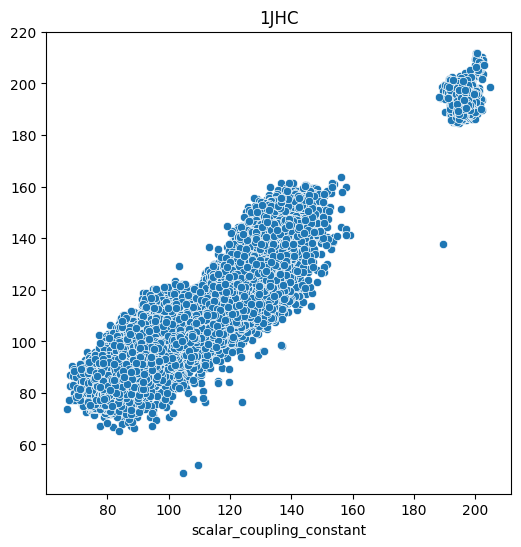

training type: 1JHN
	train mae: 0.5948036597497063
	val mae: 0.5801204837293589
	mean: 47.58888593177653


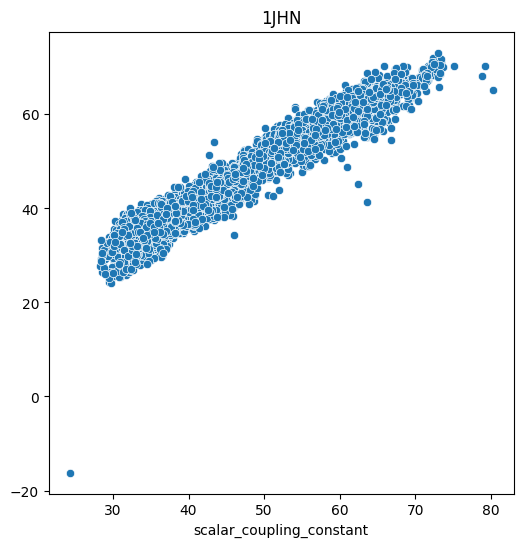

training type: 2JHC
	train mae: 0.6683906710540742
	val mae: 0.6629022113681773
	mean: -0.2861580165575423


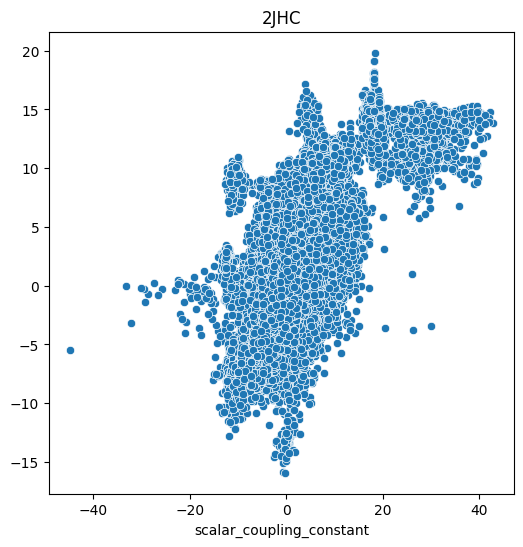

training type: 2JHH
	train mae: -0.06247574326712016
	val mae: -0.0646297728807933
	mean: -10.284791377311574


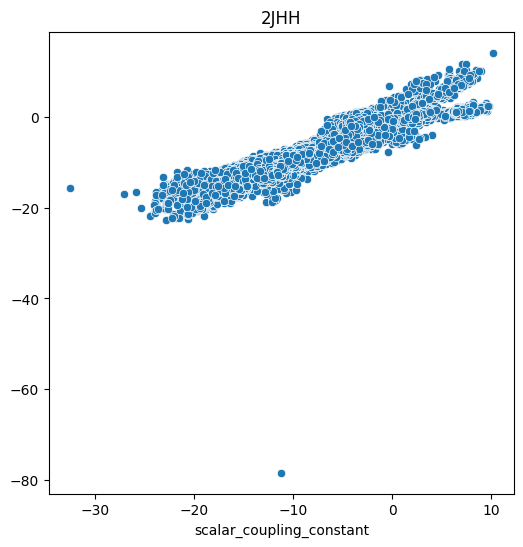

training type: 2JHN
	train mae: 0.45838721123333515
	val mae: 0.45182878834349754
	mean: 3.147258812195552


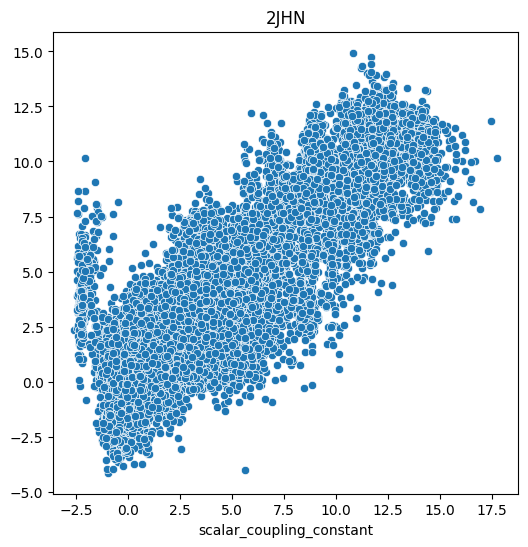

training type: 3JHC
	train mae: 0.7922864686508817
	val mae: 0.793594678115615
	mean: 3.688477471119176


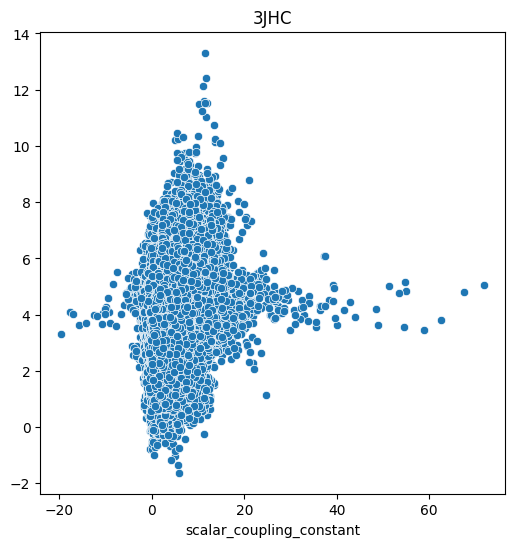

training type: 3JHH
	train mae: 0.982566085027391
	val mae: 0.9821927750145427
	mean: 4.772321552368179


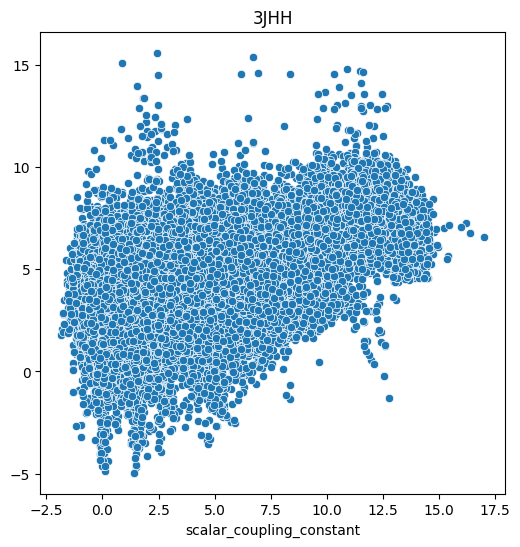

training type: 3JHN
	train mae: -0.1864856436421204
	val mae: -0.18190570724809402
	mean: 0.9997138779221542


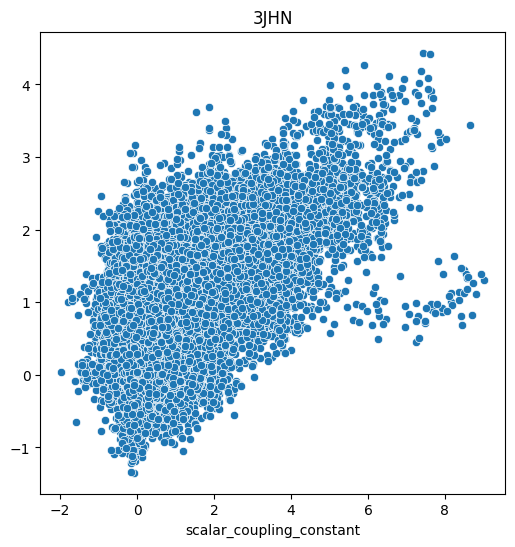

In [25]:
mae_dict, train_mae_dict, mean_dict, m_dict = {}, {}, {}, {}
mae_total = 0

for j_type in types:
  X = train[train['type'] == j_type].drop(columns=['scalar_coupling_constant', 'type'])
  y = train[train['type'] == j_type]['scalar_coupling_constant']
  print(f'training type: {j_type}')
  m_dict[j_type], train_mae_dict[j_type], mean_dict[j_type], mae_dict[j_type], val_y, pred_val_y = lr_model(X, y, j_type)
  mae_total += mae_dict[j_type]

  plt.figure(figsize=[6,6])
  sns.scatterplot(x=val_y, y=pred_val_y)
  plt.title(j_type)
  plt.show()

In [27]:
print(f'mae total = {mae_total}, mean mae = {mae_total / len(types)}')

mae total = 4.720305745393589, mean mae = 0.5900382181741987


# **Random Forest**

In [28]:
def rf_model(X, y, j_type):
  train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
  start_time = time.time()

  subset_ratio = 0.2  # using 20% of the data for tuning
  subset_X = train_X.sample(frac=subset_ratio, random_state=42)
  subset_y = train_y.loc[subset_X.index]

  def objective(space):
    m = RandomForestRegressor(
          n_estimators=int(space['n_estimators']),
          max_depth=int(space['max_depth']) if space['max_depth'] else None,
          min_samples_split=5,
          random_state=42
        )

    m.fit(subset_X, subset_y)

    # use negative MAE as loss because Hyperopt minimizes the objective
    pred_y = m.predict(val_X)
    loss = -np.log(mean_absolute_error(val_y, pred_y))
    print(f"completed trial: n_estimators: {space['n_estimators']}, max_depth: {space['max_depth']}, loss: {loss}")
    return {'loss': loss, 'status': STATUS_OK}

  '''space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'max_depth': hp.choice('max_depth', [None, 5, 10, 15, 20]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2'])
  }'''
  space = {
        'n_estimators': hp.quniform('n_estimators', 10, 100, 20),
        'max_depth': hp.choice('max_depth', [None, 5, 10]),
  }

  trials = Trials()
  best_hyperparams = fmin(fn=objective,
                          space=space,
                          algo=tpe.suggest,
                          max_evals=20,
                          trials=trials)

  print(best_hyperparams)
  depth_choices = [None, 5, 10]
  #best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])

  best_hyperparams['max_depth'] = depth_choices[best_hyperparams['max_depth']]
  best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])

  final_m = RandomForestRegressor(**best_hyperparams, random_state=42)
  final_m.fit(train_X, train_y)

  pred_train_y = final_m.predict(train_X)
  pred_val_y = final_m.predict(val_X)

  train_mae = np.log(mean_absolute_error(train_y, pred_train_y))
  val_mae = np.log(mean_absolute_error(val_y, pred_val_y))

  end_time = time.time()

  print(f'\ttrain mae: {train_mae}')
  print(f'\tval mae: {val_mae}')
  print(f'\ttotal time: {end_time - start_time}')

  print('saving final model...')
  with open(f'drive/MyDrive/senior-yr/spring-2024/cse-60625/rf_{j_type}_model.pkl', 'wb') as file:
    pickle.dump(final_m, file)

  return train_mae, val_mae, val_y, pred_val_y


training model for type: 1JHC...
completed trial: n_estimators: 50.0, max_depth: 5, loss: -1.263224778011101
completed trial: n_estimators: 30.0, max_depth: 5, loss: -1.2634167923416
completed trial: n_estimators: 30.0, max_depth: 2, loss: -1.756274168553189
completed trial: n_estimators: 20.0, max_depth: 5, loss: -1.261826360251043
completed trial: n_estimators: 20.0, max_depth: 10, loss: -0.8562119663987834
completed trial: n_estimators: 50.0, max_depth: 2, loss: -1.756419441157109
completed trial: n_estimators: 50.0, max_depth: 5, loss: -1.263224778011101
completed trial: n_estimators: 40.0, max_depth: 5, loss: -1.2626385236812534
completed trial: n_estimators: 40.0, max_depth: 5, loss: -1.2626385236812534
completed trial: n_estimators: 20.0, max_depth: 5, loss: -1.261826360251043
completed trial: n_estimators: 50.0, max_depth: 10, loss: -0.8550711009526586
completed trial: n_estimators: 50.0, max_depth: 2, loss: -1.756419441157109
completed trial: n_estimators: 20.0, max_depth: 2, 

<ipython-input-29-0f56d4c7f7e9>:9: RuntimeWarning: invalid value encountered in log
  mae_total += np.log(mae_dict[j_type])


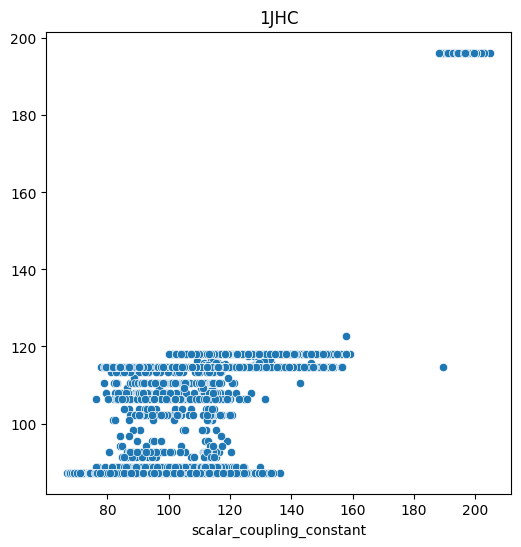

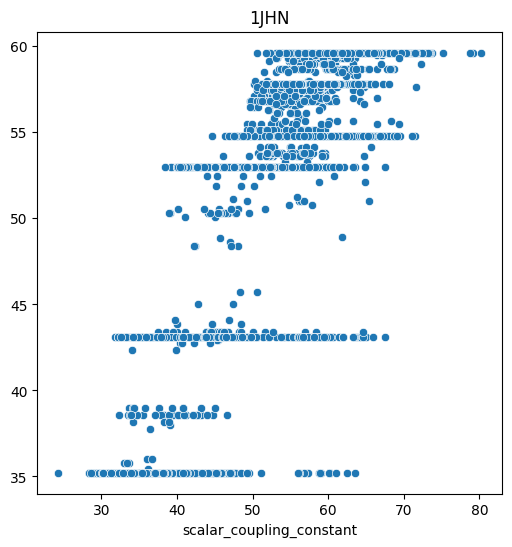

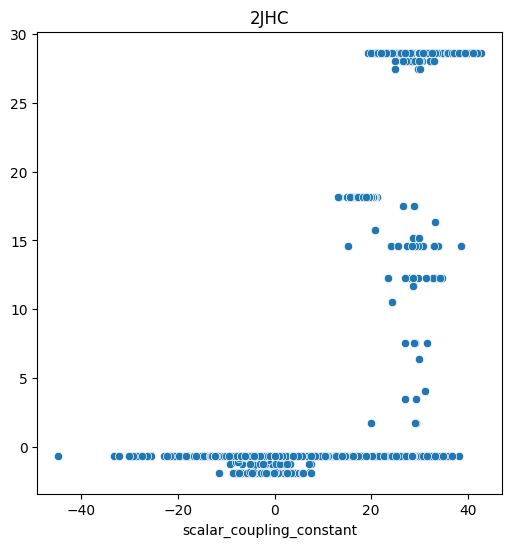

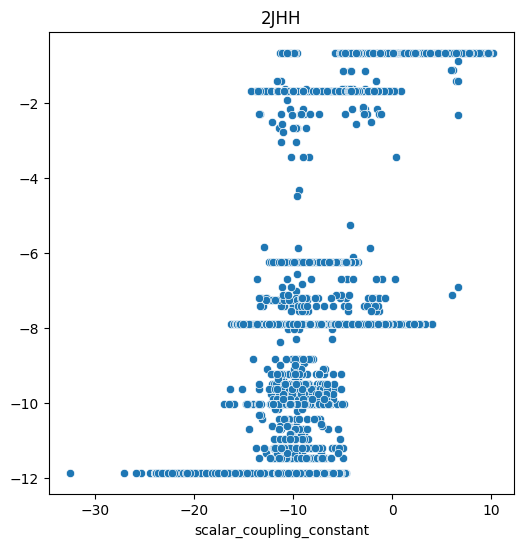

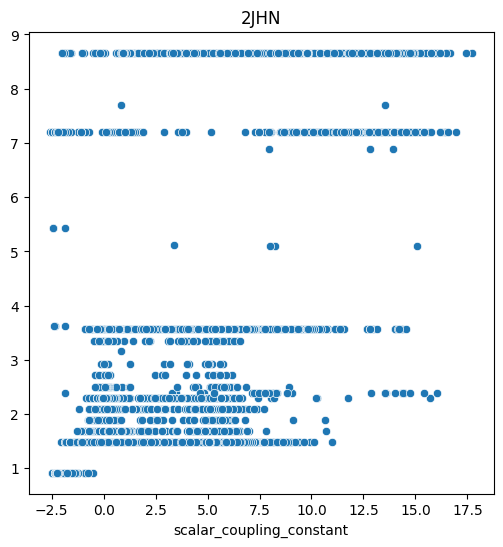

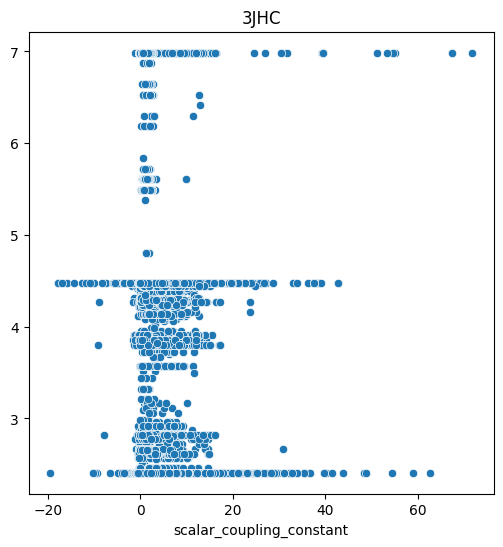

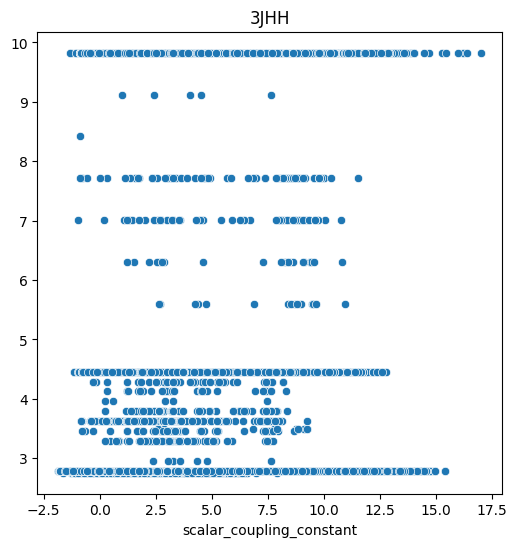

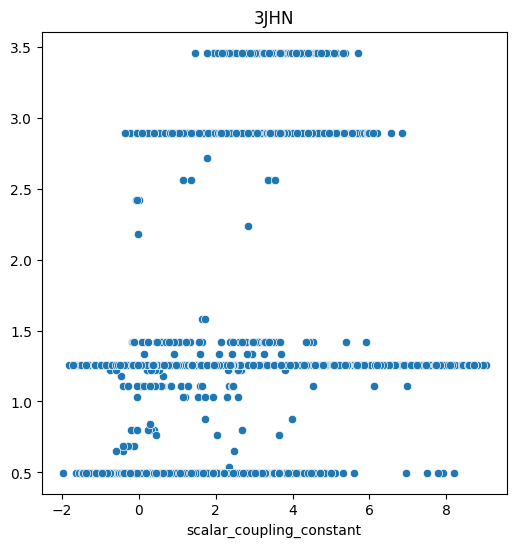

In [29]:
mae_dict, train_mae_dict= {}, {}
mae_total = 0

for j_type in types:
  X = train[train['type'] == j_type].drop(columns=['scalar_coupling_constant', 'type'])
  y = train[train['type'] == j_type]['scalar_coupling_constant']
  print(f'training model for type: {j_type}...')
  train_mae_dict[j_type], mae_dict[j_type], val_y, pred_val_y = rf_model(X, y, j_type)

  #mae_total += np.log(mae_dict[j_type])

  plt.figure(figsize=[6,6])
  sns.scatterplot(x=val_y, y=pred_val_y)
  plt.title(j_type)
  plt.show()

In [30]:
print(mae_dict)
print(f'mae total = {mae_total}, mean mae = {mae_total / len(types)}')

{'1JHC': 1.759824935114128, '1JHN': 1.1012817947893372, '2JHC': 0.834303677044864, '2JHH': 0.4481725147191081, '2JHN': 0.7059879878840064, '3JHC': 0.7229785604516168, '3JHH': 0.7469478120110958, '3JHN': -0.16141928986743867}
mae total = 6.158077992146717, mean mae = 0.7697597490183397


In [17]:
def rf_model_with_gpu(X, y, j_type):
  train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
  start_time = time.time()

  def objective(space):
    m = XGBRFRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        tree_method='hist',
        device='cuda',
    )

    m.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)

    # use negative MAE as loss because Hyperopt minimizes the objective
    pred_y = m.predict(val_X)
    loss = -np.log(mean_absolute_error(val_y, pred_y) + 1)
    return {'loss': loss, 'status': STATUS_OK}

  space = {
      'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
      'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
      'min_child_weight': hp.uniform('min_child_weight', 1, 10),
      'subsample': hp.uniform('subsample', 0.5, 1),
      'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
  }

  trials = Trials()
  best_hyperparams = fmin(fn=objective,
                          space=space,
                          algo=tpe.suggest,
                          max_evals=100,
                          trials=trials)

  best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
  best_hyperparams['max_depth'] = int(np.arange(3, 10, dtype=int)[best_hyperparams['max_depth']])

  print("best hyperparameters are: ")
  print(best_hyperparams)

  # adjust hyperparameters after optimization

  final_m = XGBRFRegressor(**best_hyperparams, tree_method = 'hist', random_state=42)
  final_m.fit(train_X, train_y)

  pred_train_y = final_m.predict(train_X)
  pred_val_y = final_m.predict(val_X)

  train_mae = np.log(mean_absolute_error(train_y, pred_train_y))
  val_mae = np.log(mean_absolute_error(val_y, pred_val_y))

  end_time = time.time()

  print(f'\ttrain MAE: {train_mae}')
  print(f'\tvalidation MAE: {val_mae}')
  print(f'\ttotal time: {end_time - start_time} seconds')

  # saving the model
  print('saving final model...')
  with open(f'xgbrf_{j_type}_model.pkl', 'wb') as file:
      pickle.dump(final_m, file)

  return train_mae, val_mae, val_y, pred_val_y

training model for type: 1JHC...
100%|██████████| 100/100 [18:20<00:00, 11.01s/trial, best loss: -1.7030705308448895]
best hyperparameters are: 
{'colsample_bytree': 0.9873908783344103, 'max_depth': 3, 'min_child_weight': 4.767816871910378, 'n_estimators': 900, 'subsample': 0.9999043073495243}
	train MAE: 1.5015843313915038
	validation MAE: 1.501622435273497
	total time: 1134.427651166916 seconds
saving final model...


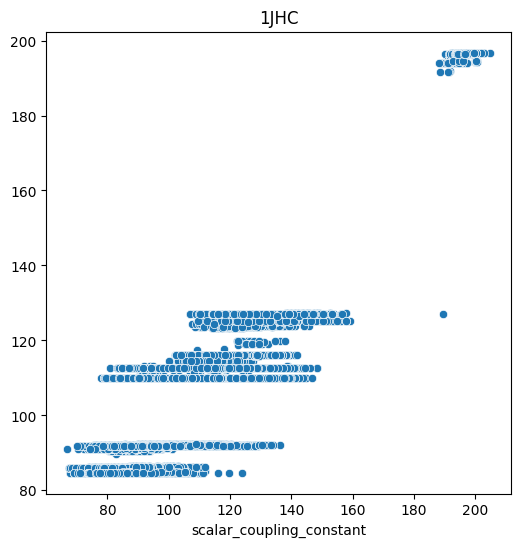

training model for type: 1JHN...
100%|██████████| 100/100 [05:30<00:00,  3.31s/trial, best loss: -1.1760597522210552]
best hyperparameters are: 
{'colsample_bytree': 0.5117770532476719, 'max_depth': 3, 'min_child_weight': 2.111865882716966, 'n_estimators': 560, 'subsample': 0.9879701571475497}
	train MAE: 0.7880134480279158
	validation MAE: 0.8061531437086099
	total time: 332.586599111557 seconds
saving final model...


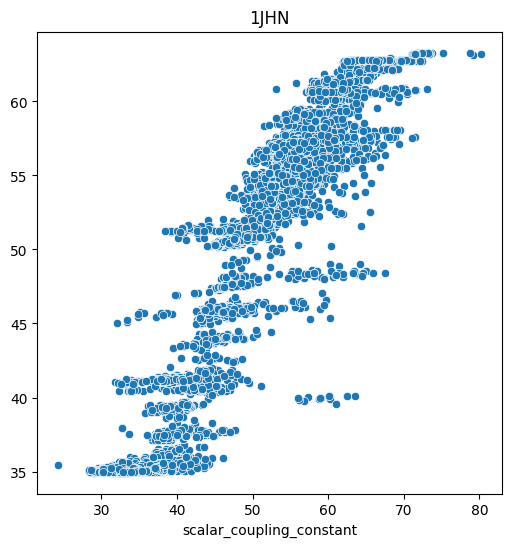

training model for type: 2JHC...
100%|██████████| 100/100 [22:32<00:00, 13.52s/trial, best loss: -1.1023386970356417]
best hyperparameters are: 
{'colsample_bytree': 0.984781548272654, 'max_depth': 3, 'min_child_weight': 4.253144391873007, 'n_estimators': 460, 'subsample': 0.785695182537581}
	train MAE: 0.6919778258414755
	validation MAE: 0.6873487952986005
	total time: 1378.46728348732 seconds
saving final model...


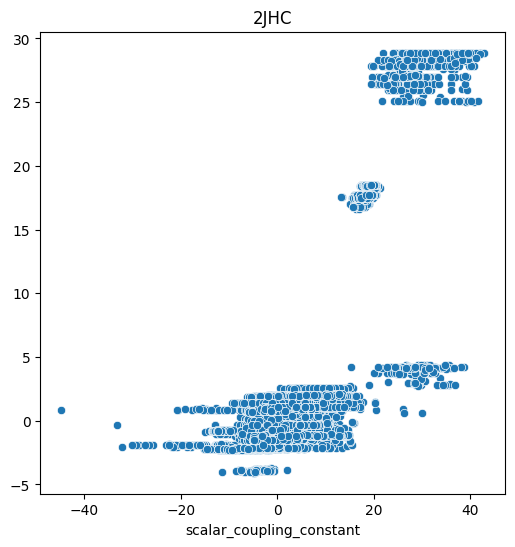

training model for type: 2JHH...
100%|██████████| 100/100 [10:26<00:00,  6.26s/trial, best loss: -0.7988287992633881]
best hyperparameters are: 
{'colsample_bytree': 0.5117430780590388, 'max_depth': 3, 'min_child_weight': 1.7764242550832445, 'n_estimators': 620, 'subsample': 0.9914935129829522}
	train MAE: 0.19968597959208834
	validation MAE: 0.1955953667975965
	total time: 637.8919203281403 seconds
saving final model...


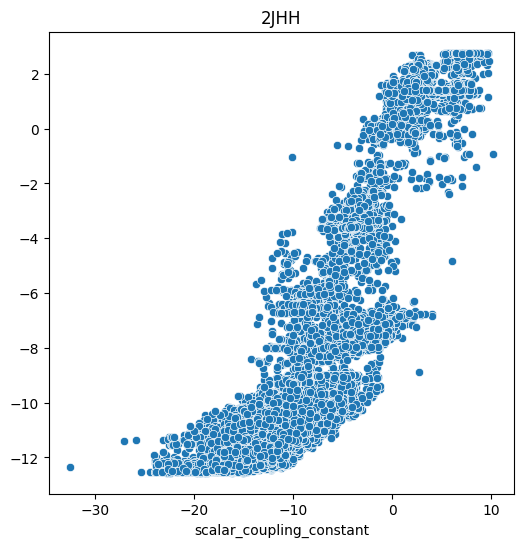

training model for type: 2JHN...
100%|██████████| 100/100 [06:13<00:00,  3.73s/trial, best loss: -0.992146488865786]
best hyperparameters are: 
{'colsample_bytree': 0.500491952336637, 'max_depth': 3, 'min_child_weight': 2.8273355914127727, 'n_estimators': 770, 'subsample': 0.9692773612978807}
	train MAE: 0.5263880746795967
	validation MAE: 0.5300957351622081
	total time: 378.2310254573822 seconds
saving final model...


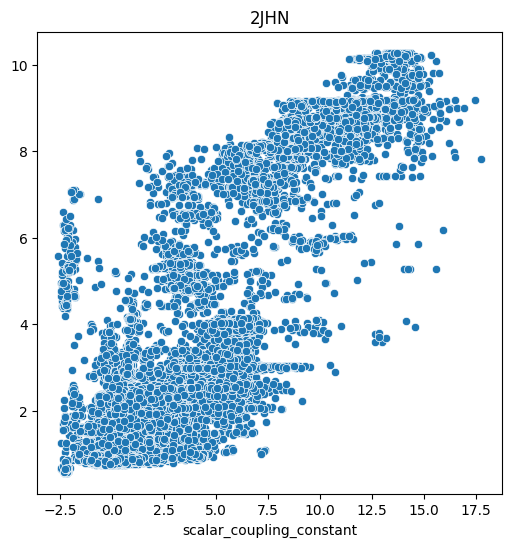

training model for type: 3JHC...
100%|██████████| 100/100 [29:59<00:00, 18.00s/trial, best loss: -1.134797108077192]
best hyperparameters are: 
{'colsample_bytree': 0.5269080335037508, 'max_depth': 3, 'min_child_weight': 7.906171986055827, 'n_estimators': 500, 'subsample': 0.7127994247132684}
	train MAE: 0.7285600993665736
	validation MAE: 0.7297460763190318
	total time: 1840.646428823471 seconds
saving final model...


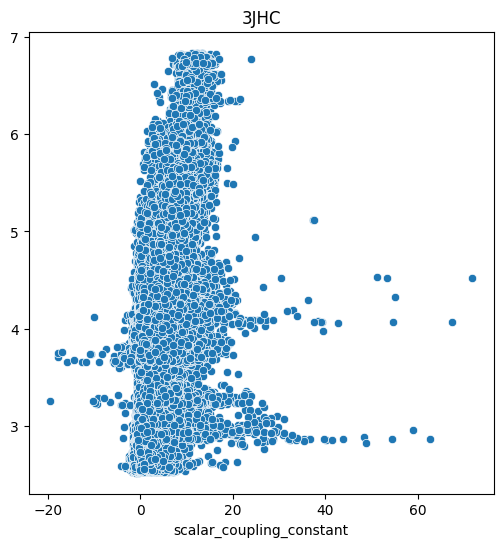

training model for type: 3JHH...
100%|██████████| 100/100 [16:06<00:00,  9.66s/trial, best loss: -1.1913502226690171]
best hyperparameters are: 
{'colsample_bytree': 0.5271988953329677, 'max_depth': 3, 'min_child_weight': 7.192281237638301, 'n_estimators': 420, 'subsample': 0.9028200503356907}
	train MAE: 0.7823379671738456
	validation MAE: 0.7827845349458042
	total time: 981.1830294132233 seconds
saving final model...


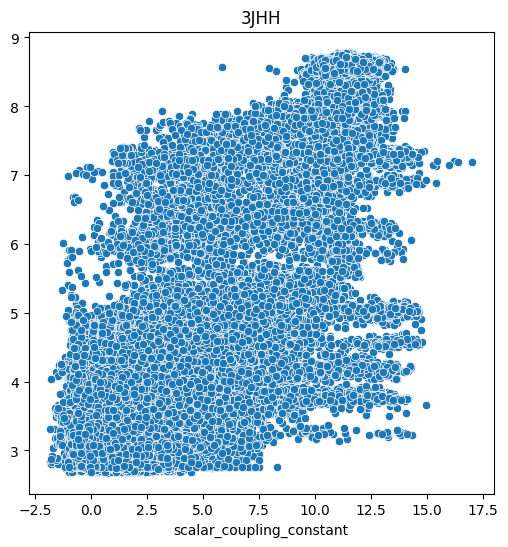

training model for type: 3JHN...
100%|██████████| 100/100 [07:07<00:00,  4.28s/trial, best loss: -0.5869591463289048]
best hyperparameters are: 
{'colsample_bytree': 0.5151605697973864, 'max_depth': 3, 'min_child_weight': 2.152635768904072, 'n_estimators': 500, 'subsample': 0.5940391509346479}
	train MAE: -0.2370969287776568
	validation MAE: -0.2306297358235636
	total time: 432.4691002368927 seconds
saving final model...


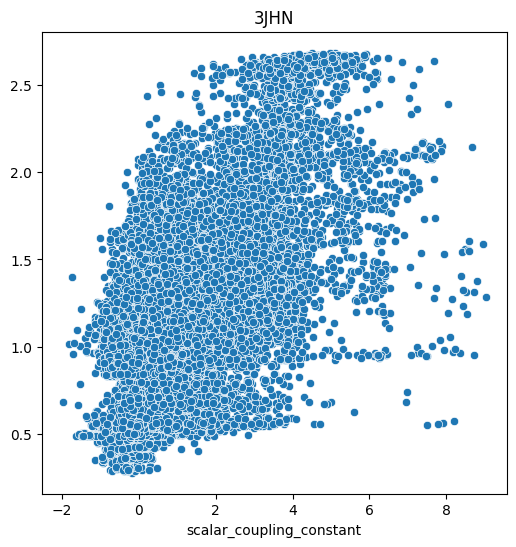

In [18]:
mae_dict, train_mae_dict= {}, {}
mae_total = 0

for j_type in types:
  X = train[train['type'] == j_type].drop(columns=['scalar_coupling_constant', 'type'])
  y = train[train['type'] == j_type]['scalar_coupling_constant']
  print(f'training model for type: {j_type}...')
  train_mae_dict[j_type], mae_dict[j_type], val_y, pred_val_y = rf_model_with_gpu(X, y, j_type)

  mae_total += mae_dict[j_type]

  plt.figure(figsize=[6,6])
  sns.scatterplot(x=val_y, y=pred_val_y)
  plt.title(j_type)
  plt.show()

In [19]:
print(mae_dict)
print(f'mae total = {mae_total}, mean mae = {mae_total / len(types)}')

{'1JHC': 1.501622435273497, '1JHN': 0.8061531437086099, '2JHC': 0.6873487952986005, '2JHH': 0.1955953667975965, '2JHN': 0.5300957351622081, '3JHC': 0.7297460763190318, '3JHH': 0.7827845349458042, '3JHN': -0.2306297358235636}
mae total = 5.002716351681785, mean mae = 0.6253395439602232
